# Binary Classification with the UCI Credit Card Payment Default Dataset
_**Mitigating introduced demographic disparities in the UCI default of credit card clients dataset**_

## Summary:

1. [Introduction](#Introduction)
2. [The UCI Credit Card Payment Default Dataset](#The-UCI-Credit-Card-Payment-Default-Dataset)
3. [Using a Fairness Unaware Model](#Using-a-Fairness-Unaware-Model)
4. [Mitigating Demographic Disparities with Postprocessing Techniques](#Mitigating-Demographic-Disparities-with-Postprocessing-Techniques)
5. [Mitigating Demographic Disparities with GridSearch](#Mitigating-Demographic-Disparities-with-GridSearch)

# Introduction

In this example, we emulate the problem of demographic disparities in access to financial instruments. Such issues arise when the datasets used to train algorithms involved in resource allocation are biased towards a particular demographic segment. This can happen even when precautions are taken, for example when the sensitive attribute is removed from the dataset. See [here](https://www.nytimes.com/2019/11/10/business/Apple-credit-card-investigation.html) for a recent example involving sex-based discrimination for credit limit allocation.  

For this scenario, we use the [UCI dataset](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) on credit card default payments in 2005 in Taiwan. Since the UCI dataset does not intrisically contain demographic disparities, we introduce a credit limit feature that is biased towards sex: this feature has predictive power for whether a female client will default, but not for male clients. This is one way in which demographic disparities can leak into the dataset despite removing sensitive demographic information.

We begin by training a regular machine learning model on the biased data and show how the model performance differs for male and female clients. We use `fairlearn` to mitigate these differences using the `ThresholdOptimizer` and `GridSearch` techniques implemented in the package. 

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn models and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds
from fairlearn.widget import FairlearnDashboard

# Metrics
from fairlearn.metrics import group_selection_rate, group_zero_one_loss, group_recall_score, \
                              metric_by_group, group_roc_auc_score
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, roc_auc_score

C:\Users\moprescu\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\moprescu\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\moprescu\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# The UCI Credit Card Payment Default Dataset

The UCI datasets contains on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the data contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. The target is whether the client will default on a card payment in the following month, October 2005. One can imagine that a model trained on this data can be used in practice to determine whether a client is eligible for another product offering such as an auto loan. 

In [2]:
# Load the data
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a biased feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for the April-September months
* `PAY_AMT[1-6]`: payment amount for the April-September months
* `default payment next month`: target, whether the customer defaulted the following month

In [3]:
# Sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Target
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
dataset = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)

## Introduce Bias w.r.t. Sex

We manipulate the balance limit feature `LIMIT_BAL`such that this feature is highly predictive for females but not for males. For example, we can imagine that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [4]:
dist_scale = 0.5
np.random.seed(12345)
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

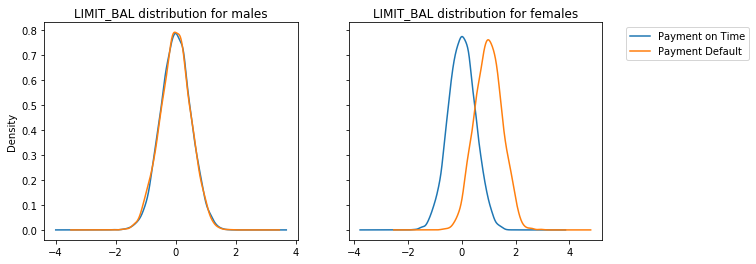

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for males
dataset['LIMIT_BAL'][(A==1) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax1, 
                                           title="LIMIT_BAL distribution for males")
dataset['LIMIT_BAL'][(A==1) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax1)
# Plot distribution of LIMIT_BAL for females
dataset['LIMIT_BAL'][(A==2) & (Y==0)].plot(kind='kde', label="Payment on Time", ax=ax2, 
                                           legend=True, title="LIMIT_BAL distribution for females")
dataset['LIMIT_BAL'][(A==2) & (Y==1)].plot(kind='kde', label="Payment Default", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

We notice form the above figures that the new `LIMIT_BAL` feature is a good discriminant for female customers, but not for male ones.

In [6]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

# Using a Fairness Unaware Model

We train an out-of-the-box `lightgbm` model on the biased data and assess several disparity metrics. 

In [7]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [8]:
model = lgb.LGBMClassifier(**lgb_params)

In [9]:
model.fit(df_train, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.03, max_depth=3,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=10,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [10]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [11]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.8479786254849431

In [12]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

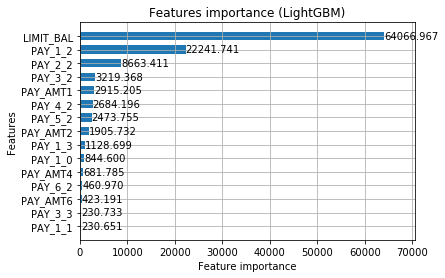

In [13]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We notice that the biased feature `LIMIT_BAL`, appears as the most important feature in this model although it has no predictive power for an entire demographic segment in the data. 

In [14]:
# Helper functions
def group_equalized_odds_diff(y_true, y_pred, group):
    TPR_diff = group_recall_score(y_true, y_pred, group).range
    TNR_diff = group_recall_score(1-y_true, 1-y_pred, group).range
    return max(TPR_diff, TNR_diff)

def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Demographic parity difference": (lambda x: group_selection_rate(y_true, x, group).range, True),
        "Demographic parity ratio": (lambda x: group_selection_rate(y_true, x, group).range_ratio, True),
        "Error rate difference": (
            lambda x: metric_by_group(balanced_accuracy_score, y_true, x, group).range, True),
        "Equal opportunity difference": (lambda x: group_recall_score(y_true, x, group).range, True),
        "Equalized odds difference": (lambda x: group_equalized_odds_diff(y_true, x, group), True),
        "Group AUC difference": (lambda x: group_roc_auc_score(y_true, x, group).range, False),
        "Overall AUC": (lambda x: roc_auc_score(y_true, x), False)
        }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

We calculate several disparity metrics below:

In [15]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Demographic parity difference,0.049844
Demographic parity ratio,0.833288
Error rate difference,0.177234
Equal opportunity difference,0.343066
Equalized odds difference,0.343066
Group AUC difference,0.190962
Overall AUC,0.849865


# Mitigating Demographic Disparities with Postprocessing Techniques

We attempt to mitigate the disparities in the `lightgbm` prediction using the `fairlearn` postprocessing technique `ThersholdOptimizer`. This technique will find a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model such that the demographic disparities are minimized. For this exercise, we focus on the `equalized odds` disparity metric.

In [16]:
class LGBMClassifierWrapper:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self, X, y):
        self.model.fit(X, y)
        return self.model
    
    def predict(self, X):
        return self.model.predict_proba(X)[:, 1]

In [17]:
postprocess_est = ThresholdOptimizer(
    unconstrained_predictor=LGBMClassifierWrapper(model),
    constraints="equalized_odds")

In [18]:
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

In [19]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [20]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

In [21]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [22]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Demographic parity difference,0.049844,0.015294
Demographic parity ratio,0.833288,0.963336
Error rate difference,0.177234,0.004606
Equal opportunity difference,0.343066,0.009298
Equalized odds difference,0.343066,0.009298
Group AUC difference,0.190962,0.004606
Overall AUC,0.849865,0.685778


We note that the `ThresholdOptimizer` method significantly reduces demographic disparity accross multiple metrics. 

Below, we compare this model with the unmitigated `lightgbm` model using the `fairlearn` dashboard. 

**Gender fairness: Dashboard demo**

In [23]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred={"Unmitigated": test_preds,
                          "ThresholdOptimizer": postprocess_preds})

FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…

# Mitigating Demographic Disparities with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm from `fairlearn`.

In [24]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=41,
                   grid_limit=2)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


In [25]:
sweep_preds = [result.predictor.predict(df_test) for result in sweep.all_results] 
sweep_scores = [result.predictor.predict_proba(df_test)[:, 1] for result in sweep.all_results] 

In [26]:
equalized_odds_sweep = [
    group_equalized_odds_diff(Y_test, preds, A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

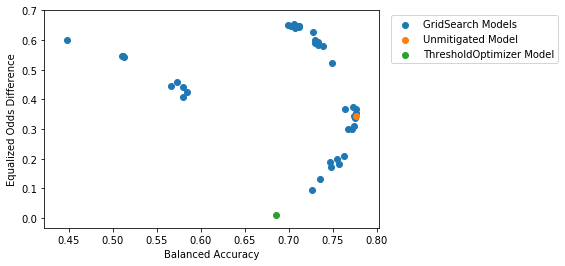

In [27]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_sweep, equalized_odds_sweep, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds), group_equalized_odds_diff(Y_test, test_preds, A_str_test), 
           label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            group_equalized_odds_diff(Y_test, postprocess_preds, A_str_test) , label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

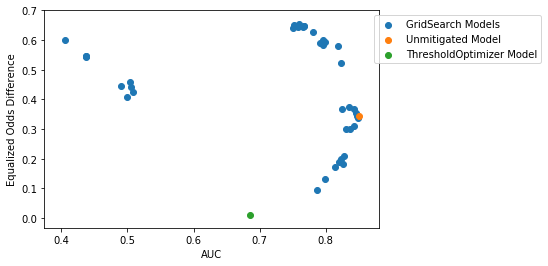

In [28]:
# Plot equalized odds difference vs auc
plt.scatter(auc_sweep, equalized_odds_sweep, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores), group_equalized_odds_diff(Y_test, test_preds, A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            group_equalized_odds_diff(Y_test, postprocess_preds, A_str_test) , label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show()

In [29]:
model_sweep_dict = {"GridSearch_{}".format(i): sweep_preds[i] for i in range(len(sweep_preds))}
model_sweep_dict.update({"Unmitigated": test_preds, "ThresholdOptimizer": postprocess_preds})

**Gender fairness: Dashboard demo**

We compare the GridSearch candidate models with the unmitigated `lightgbm` and the threshold optimized model using the `fairlearn` dashboard. 

In [30]:
FairlearnDashboard(sensitive_features=A_str_test, sensitive_feature_names=['Sex'],
                   y_true=Y_test,
                   y_pred=model_sweep_dict)

FairlearnWidget(value={'true_y': [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1…